# Feature Importances with Random Forest Classifier

In [1]:
import os 
import pandas as pd
import numpy as np
import sys 
import matplotlib.pyplot as plt

# import sklearn methods 
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from utils3 import *

from sklearn.inspection import permutation_importance

Prepare dataset:

In [2]:
df_original = pd.read_pickle('../input/subjectwise-normalized-df/final_step2.pkl')

#drop rows == -1 in drowsiness
df_original = df_original.loc[ np.logical_or(df_original['DROWSINESS'] == 1, df_original['DROWSINESS'] == 0 ) ]
df_original.loc[df_original['DROWSINESS'] == 1, 'DROWSINESS'].count()

X = df_original.loc[:, ["n_EAR", 
                    "n_MAR", "n_MOE", "n_EC",
                    "n_LEB", "n_SOP", "PERCLOS", "CLOSENESS"]]

y = df_original.loc[:, "DROWSINESS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# cross-validation with 5 splits
cross_val = StratifiedShuffleSplit(n_splits=10, random_state = 42)

Hyperparameter searching:

In [3]:
rf = RandomForestClassifier(random_state = 0,criterion='entropy',class_weight='balanced',max_features=None)

# parameters 
parameters = {  
                "n_estimators":[20],
                #'max_depth': list(range(1,11)),
                #"criterion": ["gini","entropy"],
                #"class_weight": [None, "balanced"],
                #"max_features":["auto", None, "log2"],
                }

# grid search for parameters
grid = GridSearchCV(estimator=rf, param_grid=parameters, cv=cross_val, n_jobs=-1)#multithreading; all cores are used
grid.fit(X_train, y_train)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'n_estimators': 20} with a score of 0.7865


Predictions:

In [4]:
# prediction results
y_pred = grid.predict(X_test)

# print accuracy metrics
results, false = display_test_scores_v2(y_test, y_pred)
print(results)

TEST SCORES

ACCURACY: 0.7894

AUC: 0.7824

CONFUSION MATRIX:
[[37679 13146]
 [12735 59359]]

FALSE POSITIVES:
12735 out of 72094 positive labels (0.1766%)

FALSE NEGATIVES:
13146 out of 50825 negative labels (0.2587%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74     50825
           1       0.82      0.82      0.82     72094

    accuracy                           0.79    122919
   macro avg       0.78      0.78      0.78    122919
weighted avg       0.79      0.79      0.79    122919



Show feature importances:


([<matplotlib.patches.Wedge at 0x7f9d06726290>,
 [Text(-0.5104790962437803, 0.9743772843709636, 'n_EAR'),
  Text(-1.0999953084278362, -0.003212699293402883, 'n_MAR'),
  Text(-0.5632317460013413, -0.9448650698889661, 'n_MOE'),
  Text(0.23025066338870873, -1.0756322010841157, 'n_EC'),
  Text(0.9704514971704664, -0.5179033612939778, 'n_LEB'),
  Text(1.028747320140051, 0.38945981988475226, 'n_SOP'),
  Text(0.5008749321522318, 0.9793489175679408, 'PERCLOS'),
  Text(0.025122147250259155, 1.0997130888179592, 'CLOSENESS')])

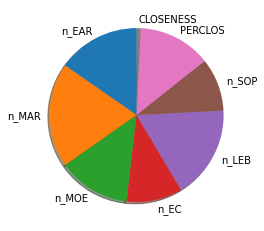

In [5]:
# pie-chart 
labels = X_train.columns
plt.pie(grid.best_estimator_.feature_importances_, labels=labels, shadow=True, startangle=90) 

# Permutation Importance:

see https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

and https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

**Train Set**

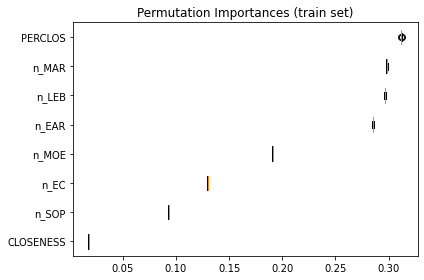

PERCLOS  0.312 +/- 0.000
n_MAR    0.298 +/- 0.001
n_LEB    0.297 +/- 0.000
n_EAR    0.285 +/- 0.000
n_MOE    0.191 +/- 0.000
n_EC     0.130 +/- 0.000
n_SOP    0.093 +/- 0.000
CLOSENESS 0.018 +/- 0.000


In [6]:
from sklearn.inspection import permutation_importance

result = permutation_importance(grid, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
         print(f"{X_train.columns[i]:<8} "
               f"{result.importances_mean[i]:.3f}"
               f" +/- {result.importances_std[i]:.3f}")

**Test Set**



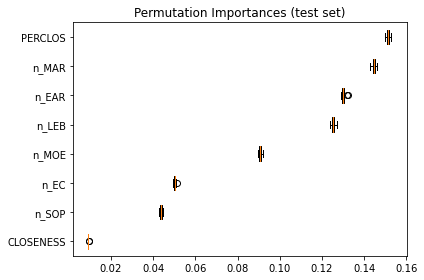

PERCLOS  0.151 +/- 0.001
n_MAR    0.145 +/- 0.001
n_EAR    0.130 +/- 0.001
n_LEB    0.125 +/- 0.001
n_MOE    0.091 +/- 0.001
n_EC     0.050 +/- 0.001
n_SOP    0.044 +/- 0.001
CLOSENESS 0.009 +/- 0.000


In [7]:
result = permutation_importance(grid, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
         print(f"{X_test.columns[i]:<8} "
               f"{result.importances_mean[i]:.3f}"
               f" +/- {result.importances_std[i]:.3f}")